## A Comparative Study of Classification and Regression Models for Intelligent Beam Selection in 5G Systems

**Prepared by Robin Wang**

---

### Executive Summary

Modern 5G wireless networks rely on directional beamforming to achieve high data rates, particularly in millimeter-wave (mmWave) systems. However, selecting the optimal beam typically requires exhaustive beam sweeping, which increases latency, signaling overhead, and reduces spectral efficiency.

This capstone project develops and compares supervised machine learning models for predicting the optimal beam index and corresponding beam quality using Channel State Information (CSI). By replacing exhaustive beam search with intelligent prediction, the system demonstrates how AI can improve wireless efficiency and reduce beam training overhead.

The study evaluates multiple classification and regression algorithms, including linear models, tree-based models, ensemble methods, and neural networks, to determine the most effective approach for intelligent beam selection.


### 1: Understanding the Data

#### Data Sources
Primary dataset: **DeepMIMO – O1_60 Scenario**  
Official Website: [https://www.deepmimo.net/](https://www.deepmimo.net/)  

The dataset provides:
- Massive MIMO CSI matrices
- User positions
- Ray-tracing-based propagation environment

### 2: Read in the Data (Data Acquisition)

Generate the dataset and import all the necessary modules, install ***deepmimo*** module first

`python
pip install --pre deepmimo
`

In [1]:
# Standard modules
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Classification
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score)
from sklearn.svm import SVC

# Regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import (mean_absolute_error, mean_squared_error, r2_score)
from sklearn.compose import ColumnTransformer

# Pipeline
from sklearn.pipeline import Pipeline

# Dataset module
import deepmimo as dm

# Warning handling
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

dm.download() performs three steps:
1. Downloads the scenario zip to "deepmimo_scenarios_downloaded/<scenario_name>.zip"
2. Extracts the scenario zip
3. Places the extracted folder under "deepmimo_scenarios/<scenario_name>" where it is accessible by dm.load() and dm.generate() functions.

In [8]:
# Load the dataset
scenarios = dm.search()
dm.summary('o1_60')

if 'o1_60' in scenarios and not os.path.exists('deepmimo_scenarios/o1_60'):
    dm.download('o1_60')


DeepMIMO o1_60 Scenario Summary

[Ray-Tracing Configuration]
- Ray-tracer: Remcom Wireless Insite v3.3
- Frequency: 60.0 GHz

[Ray-tracing parameters]

Main interaction limits
- Max path depth: 4
- Max reflections: 4
- Max diffractions: 0
- Max scatterings: 0
- Max transmissions: 0

Diffuse Scattering
- Diffuse scattering: Disabled

Terrain
- Terrain reflection: True
- Terrain diffraction: False
- Terrain scattering: False

Ray Casting Settings
- Number of rays: 259,200
- Casting method: uniform
- Casting range (az): 360.0°
- Casting range (el): 180.0°
- Synthetic array: True

[Scene]
- Number of scenes: 1
- Total objects: 33
- Vertices: 325
- Faces: 231
- Triangular faces: 33

[Materials]
Total materials: 2

ITU Layered drywall 3.5 GHz:
- Permittivity: 2.94
- Conductivity: 0.03 S/m
- Scattering model: none
- Scattering coefficient: 0.02
- Cross-polarization coefficient: 0.40

Wet earth:
- Permittivity: 25.00
- Conductivity: 0.02 S/m
- Scattering model: none
- Scattering coefficient: 

In [33]:
# Load raytracing data and creates a Dataset or MacroDataset instance.
ds = dm.load(
    'o1_60', 
    max_paths=5,  # Maximum number of paths to load, below max 10 paths
    tx_sets=[10],  # Transmitter sets to load, choose one of  [10, 11, 12]
    rx_sets=[1],   # Receiver sets to load, choose one of  [0, 1, 2]
    matrices=['tx_pos', 'rx_pos', 'aoa_az', 'aoa_el', 'aod_az', 'aod_el', 'power', 'delay', 'phase']  # List of matrix names to load
)

print(f'tx_pos shape: {ds['tx_pos'].shape}')
print(f'rx_pos shape: {ds['rx_pos'].shape}')
print(f'aoa_az shape: {ds['aoa_az'].shape}')

Loading TXRX PAIR: TXset 10 (tx_idx 0) & RXset 1 (rx_idxs 199281)
tx_pos shape: (1, 3)
rx_pos shape: (199281, 3)
aoa_az shape: (199281, 5)


### 3: Understanding the Features and Data Preprocessing

In [40]:
# Reduce the size of rx account
N = ds['rx_pos'].shape[0]

rng = np.random.default_rng(42)
idx = rng.choice(N, size=10000, replace=False) if N >= 10000 else 1

# Build CSI dataset
tx_pos = ds['tx_pos'][0]  # only a 3d point
rx_pos = ds['rx_pos'][idx]
aoa_az = ds['aoa_az'][idx]
aoa_el = ds['aoa_el'][idx]
aod_az = ds['aod_az'][idx]
aod_el = ds['aod_el'][idx] 
power = ds['power'][idx]  # dBm
delay = ds['delay'][idx] #  second
phase = ds['phase'][idx] # degree


In [65]:
"""
1) Use multipath ray-tracing parameters to synthesize an effective TX-side channel vector h
2) Apply a beam codebook W and compute per-beam gain |h^H w_k|^2
3) Labels:
   - Classification: best_beam_index = argmax_k gain_k
   - Regression: best_beam_gain = max_k gain_k
   - Regression: snr_db = 10 log10(best_beam_gain / noise)
4) Build a fixed-length feature matrix X (one row per user):
   - Geometry: distance, azimuth, elevation (from rx_pos and tx_pos)
   - Multipath features: power-weighted AoD/AoA stats + delay stats + power stats
 5) Save as .npz for reuse.
"""


# Circular statistics for angles (azimuth is circular)
def circular_mean_deg(theta_deg: np.ndarray, w: np.ndarray) -> np.ndarray:
    """
    Power-weighted circular mean angle (degrees).
    theta_deg: (U,P)
    w:         (U,P) nonnegative weights
    returns:   (U,) in (-180, 180]
    """
    theta = np.deg2rad(theta_deg)
    s = np.nansum(w * np.sin(theta), axis=1)
    c = np.nansum(w * np.cos(theta), axis=1)
    return np.rad2deg(np.arctan2(s, c))

def circular_var_unitless(theta_deg: np.ndarray, w: np.ndarray) -> np.ndarray:
    """
    Power-weighted circular variance (unitless): 1 - R, where R is mean resultant length.
    """
    theta = np.deg2rad(theta_deg)
    s = np.nansum(w * np.sin(theta), axis=1)
    c = np.nansum(w * np.cos(theta), axis=1)
    W = np.nansum(w, axis=1) + 1e-12
    R = np.sqrt(s*s + c*c) / W  # 0..1
    return 1.0 - R


# DFT codebook for a ULA
def dft_codebook_ula(N_ant: int = 64, K_beams: int = 64) -> np.ndarray:
    """
    ULA DFT codebook W of shape (K_beams, N_ant).
    """
    n = np.arange(N_ant)                 # (N,)
    k = np.arange(K_beams)[:, None]      # (K,1)
    W = np.exp(-1j * 2*np.pi * k * n / K_beams) / np.sqrt(N_ant)
    return W


# ULA steering vector using AoD azimuth (simplified)
def ula_steering(N_ant: int, theta_deg: np.ndarray) -> np.ndarray:
    """
    theta_deg: (U,P) AoD azimuth in degrees
    returns:   (U,P,N_ant) steering vectors

    Simplified model: spatial frequency proportional to sin(theta).
    """
    theta = np.deg2rad(theta_deg)
    n = np.arange(N_ant)[None, None, :]  # (1,1,N)
    A = np.exp(1j * np.pi * n * np.sin(theta)[:, :, None]) / np.sqrt(N_ant)
    return A

# Build effective channel h from multipath parameters
def build_effective_h(
    power_db: np.ndarray,
    phase_deg: np.ndarray,
    aod_az_deg: np.ndarray,
    N_ant: int = 64
) -> np.ndarray:
    """
    power_db:  (U,P) dB-like path power (may contain NaN)
    phase_deg: (U,P) phase (degrees) (may contain NaN)
    aod_az_deg:(U,P) AoD azimuth (degrees) (may contain NaN)

    returns: h (U,N_ant) complex

    Notes:
    - Treat power_db as a relative dB measure; converting to linear preserves ordering.
    - Invalid paths contribute 0.
    """
    valid = np.isfinite(power_db) & np.isfinite(phase_deg) & np.isfinite(aod_az_deg)

    # dB -> linear, invalid -> 0
    p_lin = 10.0 ** (np.where(valid, power_db, -np.inf) / 10.0)
    p_lin = np.where(np.isfinite(p_lin), p_lin, 0.0)

    # phase to radians, invalid -> 0
    ph = np.deg2rad(np.where(valid, phase_deg, 0.0))

    # complex path coefficient alpha
    alpha = np.sqrt(p_lin) * np.exp(1j * ph)  # (U,P)

    # steering vectors, invalid angles set to 0 (doesn't matter since alpha=0 there)
    A = ula_steering(N_ant, np.where(valid, aod_az_deg, 0.0))  # (U,P,N)

    # h = sum_p alpha_p * a(theta_p)
    h = np.sum(alpha[:, :, None] * A, axis=1)  # (U,N)
    return h

def best_beam_from_paths(
    power_db: np.ndarray,
    phase_deg: np.ndarray,
    aod_az_deg: np.ndarray,
    W: np.ndarray,
    batch: int = 1024
) -> tuple[np.ndarray, np.ndarray]:
    """
    Compute best beam index and best beam gain using codebook W.
    W: (K,N)

    returns:
      best_idx:  (U,) int32
      best_gain: (U,) float32
    """
    U = power_db.shape[0]
    K, N = W.shape
    best_idx = np.empty(U, dtype=np.int32)
    best_gain = np.empty(U, dtype=np.float32)

    for i in range(0, U, batch):
        sl = slice(i, min(i + batch, U))
        h = build_effective_h(power_db[sl], phase_deg[sl], aod_az_deg[sl], N_ant=N)  # (b,N)

        # gains: |h^H w_k|^2 for all beams
        proj = h @ W.conj().T                 # (b,K)
        g = (np.abs(proj) ** 2).astype(np.float32)  # (b,K)

        best_idx[sl] = np.argmax(g, axis=1)
        best_gain[sl] = np.max(g, axis=1)

    return best_idx, best_gain

# Build fixed-length features X (one row per user)
def build_features(
    tx_pos: np.ndarray,
    rx_pos: np.ndarray,
    power_db: np.ndarray,
    delay_s: np.ndarray,
    aod_az: np.ndarray,
    aod_el: np.ndarray,
    aoa_az: np.ndarray,
    aoa_el: np.ndarray
) -> np.ndarray:
    """
    tx_pos: (3,)
    rx_pos: (U,3)
    others: (U,P) with NaN

    returns X: (U,d) float32
    """
    valid = np.isfinite(power_db)
    w = 10.0 ** (np.where(valid, power_db, -np.inf) / 10.0)
    w = np.where(np.isfinite(w), w, 0.0)

    # power stats
    p_sum = np.sum(w, axis=1)
    p_max = np.max(w, axis=1)
    num_paths = np.sum(valid, axis=1).astype(np.float32)

    # delay stats (nan-safe)
    d_mean = np.nanmean(delay_s, axis=1)
    d_var = np.nanvar(delay_s, axis=1)

    # azimuth: power-weighted circular stats
    aod_az_mean = circular_mean_deg(aod_az, w)
    aod_az_cvar = circular_var_unitless(aod_az, w)
    aoa_az_mean = circular_mean_deg(aoa_az, w)
    aoa_az_cvar = circular_var_unitless(aoa_az, w)

    # elevation: plain nan stats
    aod_el_mean = np.nanmean(aod_el, axis=1)
    aod_el_var = np.nanvar(aod_el, axis=1)
    aoa_el_mean = np.nanmean(aoa_el, axis=1)
    aoa_el_var = np.nanvar(aoa_el, axis=1)

    # geometry features
    delta = rx_pos - tx_pos[None, :]
    dist = np.linalg.norm(delta, axis=1)
    az = np.rad2deg(np.arctan2(delta[:, 1], delta[:, 0]))  # [-180,180]
    el = np.rad2deg(np.arctan2(delta[:, 2], np.linalg.norm(delta[:, :2], axis=1)))

    X = np.column_stack([
        p_sum, p_max, num_paths,
        d_mean, d_var,
        aod_az_mean, aod_az_cvar,
        aoa_az_mean, aoa_az_cvar,
        aod_el_mean, aod_el_var,
        aoa_el_mean, aoa_el_var,
        dist, az, el
    ]).astype(np.float32)

    # Any remaining NaNs (e.g., users with 0 valid paths): fill with column means
    col_mean = np.nanmean(X, axis=0)
    bad = ~np.isfinite(X)
    X[bad] = np.take(col_mean, np.where(bad)[1])

    return X


#  End-to-end dataset builder
def make_dataset(
    ds,
    sample_users: int = 20000,
    seed: int = 42,
    N_ant: int = 64,
    K_beams: int = 64,
    noise_lin: float = 1e-3,
    batch: int = 1024,
    save_path: str = "capstone_o1_60_tx10_rx1.npz"
):
    """
    ds: DeepMIMO Dataset (dict-like) containing keys:
        'tx_pos','rx_pos','aoa_az','aoa_el','aod_az','aod_el','power','delay','phase'
    """
    # ---- sample users
    N = ds['rx_pos'].shape[0]
    rng = np.random.default_rng(seed)
    if sample_users is None or sample_users >= N:
        idx = np.arange(N)
    else:
        idx = rng.choice(N, size=sample_users, replace=False)

    tx_pos = ds['tx_pos'][0].astype(np.float32)

    rx_pos = ds['rx_pos'][idx].astype(np.float32)
    aoa_az = ds['aoa_az'][idx].astype(np.float32)
    aoa_el = ds['aoa_el'][idx].astype(np.float32)
    aod_az = ds['aod_az'][idx].astype(np.float32)
    aod_el = ds['aod_el'][idx].astype(np.float32)
    power = ds['power'][idx].astype(np.float32)
    delay = ds['delay'][idx].astype(np.float32)
    phase = ds['phase'][idx].astype(np.float32)

    # ---- codebook
    W = dft_codebook_ula(N_ant=N_ant, K_beams=K_beams)  # (K,N)

    # ---- labels
    y_beam, y_gain = best_beam_from_paths(power, phase, aod_az, W, batch=batch)
    y_snr_db = (10.0 * np.log10((y_gain / noise_lin) + 1e-12)).astype(np.float32)

    # ---- features
    X = build_features(tx_pos, rx_pos, power, delay, aod_az, aod_el, aoa_az, aoa_el)

    # ---- save
    np.savez(
        save_path,
        X=X,
        y_beam=y_beam,
        y_gain=y_gain,
        y_snr_db=y_snr_db,
        rx_pos=rx_pos,
        tx_pos=tx_pos,
        sample_idx=idx,
        N_ant=np.array([N_ant], dtype=np.int32),
        K_beams=np.array([K_beams], dtype=np.int32),
        noise_lin=np.array([noise_lin], dtype=np.float32),
    )

    print("Saved:", save_path)
    print("X:", X.shape, "y_beam:", y_beam.shape, "y_gain:", y_gain.shape, "y_snr_db:", y_snr_db.shape)
    print("beam_index range:", int(y_beam.min()), "to", int(y_beam.max()))
    return X, y_beam, y_gain, y_snr_db


# ============================================================
# Generate DataSet

X, y_beam, y_gain, y_snr_db = make_dataset(
    ds,
    sample_users=10000,  # start with 10k, increase later
    seed=42,
    N_ant=64,
    K_beams=64,
    noise_lin=1e-3,
    batch=1024,
    save_path="capstone_o1_60_tx10_rx1_10k_paths5_beam64.npz"
)

Saved: capstone_o1_60_tx10_rx1_10k_paths5_beam64.npz
X: (10000, 16) y_beam: (10000,) y_gain: (10000,) y_snr_db: (10000,)
beam_index range: 2 to 23


### 4: Exploratory Data Analysis (EDA)

In [71]:
# Load dataset
data = np.load("capstone_o1_60_tx10_rx1_10k_paths5_beam64.npz")

X = data['X']
y_beam = data['y_beam']
y_snr_db = data['y_snr_db']
rx_pos = data['rx_pos']
tx_pos = data['tx_pos']

# PCA for visualization
pca = PCA(n_components=2)
X2 = pca.fit_transform(X)

print("X:", X.shape)
print("y_beam:", y_beam.shape)
print("y_gain:", y_gain.shape)
print("y_snr_db:", y_snr_db.shape)

X: (10000, 16)
y_beam: (10000,)
y_gain: (10000,)
y_snr_db: (10000,)


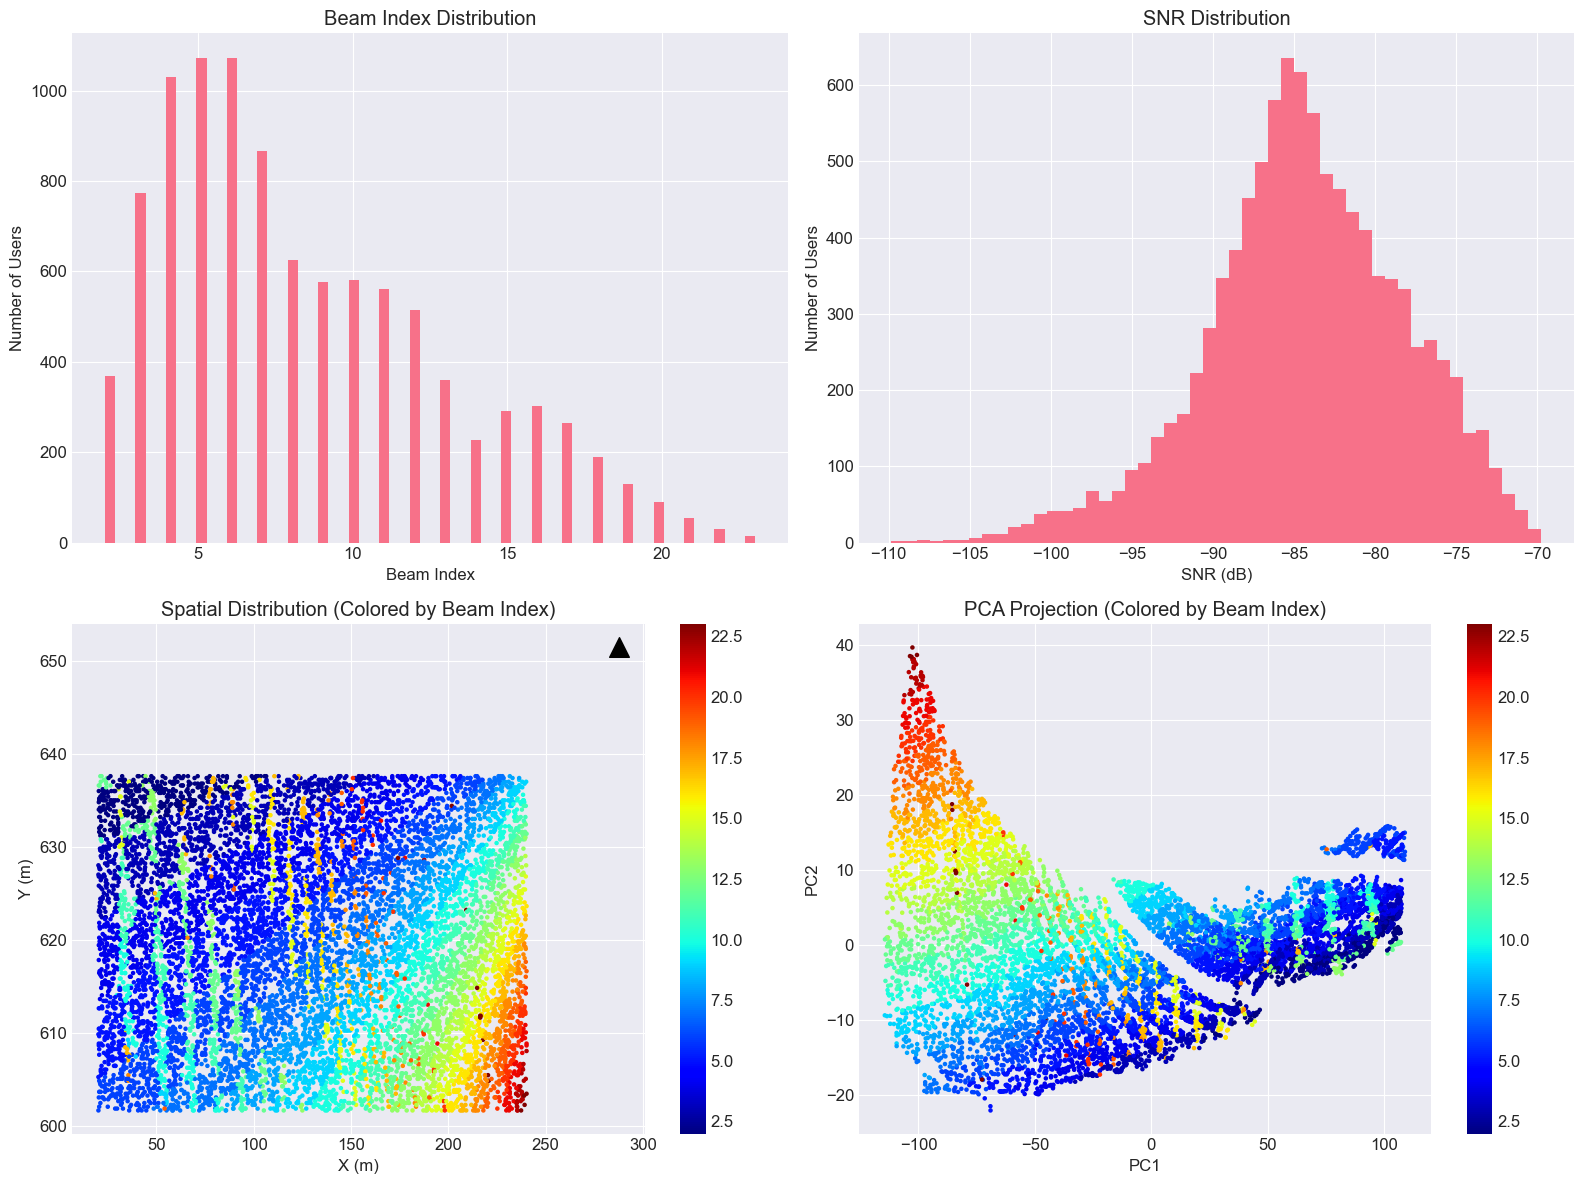

In [74]:
# Create large figure
fig, axes = plt.subplots(2, 2, figsize=(16, 12))


# Beam Index Distribution
axes[0, 0].hist(y_beam, bins=64)
axes[0, 0].set_title("Beam Index Distribution")
axes[0, 0].set_xlabel("Beam Index")
axes[0, 0].set_ylabel("Number of Users")

# SNR Distribution

axes[0, 1].hist(y_snr_db, bins=50)
axes[0, 1].set_title("SNR Distribution")
axes[0, 1].set_xlabel("SNR (dB)")
axes[0, 1].set_ylabel("Number of Users")

# Spatial Beam Map
sc1 = axes[1, 0].scatter(
    rx_pos[:, 0],
    rx_pos[:, 1],
    c=y_beam,
    s=5,
    cmap='jet'
)

axes[1, 0].scatter(
    tx_pos[0],
    tx_pos[1],
    color='black',
    marker='^',
    s=200
)

axes[1, 0].set_title("Spatial Distribution (Colored by Beam Index)")
axes[1, 0].set_xlabel("X (m)")
axes[1, 0].set_ylabel("Y (m)")
fig.colorbar(sc1, ax=axes[1, 0])

# PCA Projection
sc2 = axes[1, 1].scatter(
    X2[:, 0],
    X2[:, 1],
    c=y_beam,
    s=5,
    cmap='jet'
)

axes[1, 1].set_title("PCA Projection (Colored by Beam Index)")
axes[1, 1].set_xlabel("PC1")
axes[1, 1].set_ylabel("PC2")
fig.colorbar(sc2, ax=axes[1, 1])

plt.tight_layout()
plt.show()

### 5: Engineering Features
Prepare the features and target column for modeling with appropriate encoding and transformations.

### 6: Classification Modeling

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

### 7: Regression Modeling



### 8: Model Comparision and Selection



### 9: Conclusions
